# **Community Detection**
----

### 1. Environment Setup
Click on the button below to open the notebook in Google Colab and run the following commands to install the required libraries.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hardness1020/Community_Detection/blob/main/main.ipynb)

In [ ]:
!git clone https://github.com/hardness1020/Community_Detection.git

In [ ]:
# If using colab, change the current working directory to the location of the cloned repo
%cd Community_Detection

%pip install -r requirements.txt
!git clone https://github.com/6lyc/CDNMF.git

In [12]:
# Import packages
import os
import random
import numpy as np
import pandas as pd
import linecache
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import normalized_mutual_info_score, \
    adjusted_rand_score

# from spectral_clustering import normalize_eigenvectors, laplacian, \
#     generate_labels_dict, _init_arpack_v0
    

# # GPU
# import torch
# from scipy.optimize import linear_sum_assignment
# from CDNMF.Utils.evaluate import clusterscores
# from CDNMF.Dataset.dataset import Dataset
# from CDNMF.Model.my_model import Model
# from CDNMF.PreTrainer.pretrainer import PreTrainer
# from CDNMF.Utils import gpu_info

# # Check GPU
# device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# print('Device:', device)

### 2. Methods
- Our project implements the following community detection algorithms:
  - Spectral Clustering
  - Contrastive Deep Nonnegative Matrix Factorization (CDNMF)
- The output of the prediction of each method were stored in 'prediction/{method}_example.csv'.
  - It is not necessary to run the code to get the output file, as the output files are already stored in the repository.
  - The format of the output file is as follows:
    - Each row represents the category of the corresponding node.

#### 2.1. Spectral Clustering Method
Spectral clustering groups data by leveraging eigenvalues of a similarity graph. It is effective for complex, non-linear cluster structures.

Steps:
- **Similarity Matrix**: Compute pairwise similarities and create a graph adjacency matrix.
- **Laplacian Matrix**: Calculate the graph Laplacian (unnormalized or normalized).
- **Eigen Decomposition**: Extract eigenvectors corresponding to the smallest k eigenvalues.
- **Feature Transformation**: Use eigenvectors as features, normalizing rows if needed.
- **Clustering**: Apply k-means or similar on the transformed features.
Assign Labels: Map cluster results to the original data.

Reference:
- [Community Detection](https://github.com/VedangW/community-detection/blob/main/cdet/spectral_clustering.py)

In [22]:
# Run the spectral clustering method on the Cora dataset

cora_G = nx.read_edgelist('dataset/cora/edges.txt', nodetype=int)

n_clusters = 7  # Set this based on the known number of communities
clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0)
y_pred = clustering.fit_predict(nx.adjacency_matrix(cora_G).todense())

# Save the y_pred, each row is a node and the value is the cluster
np.savetxt('prediction/spectral.txt', y_pred, fmt='%d')

/home/hardness1020/.local/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


#### 2.2. CDNMF Method
- Recommended to use GPU for faster computation. (Colab T4 spent 30 seconds)
- Reference: 
  - Paper: [Contrastive deep nonnegative matrix factorization for community detection](https://arxiv.org/abs/2202.12345)
  - Code: [Github](https://github.com/6lyc/CDNMF?tab=readme-ov-file)

In [ ]:
# Set config

random.seed(42)

dataset_config = {'feature_file': './dataset/cora/features.txt',
                  'graph_file': './dataset/cora/edges.txt',
                  'walks_file': './dataset/cora/walks.txt',
                  'label_file': './dataset/cora/group.txt',
                  'device': device}
graph = Dataset(dataset_config)

pretrain_config = {
    'net_shape': [1000, 500, 7],
    'att_shape': [500, 200, 7],
    'net_input_dim': graph.num_nodes,
    'att_input_dim': graph.num_feas,
    'seed': 42,
    'pre_iterations': 100,
    'pretrain_params_path': './CDNMF/Log/cora/pretrain_params.pkl'}

model_config = {
    'device': device,
    'net_shape': [1000, 500, 7],
    'att_shape': [500, 200, 7],
    'net_input_dim': graph.num_nodes,
    'att_input_dim': graph.num_feas,
    'is_init': True,
    'pretrain_params_path': './CDNMF/Log/cora/pretrain_params.pkl',
    'tau': 1.3,
    'conc': 5,
    'negc': 400,
    'rec': 1,
    'r': 3,
    'learning_rate': 0.01,
    'weight_decay': 0.00001,
    'epoch': 550,
    'run': 20,
    'model_path': './CDNMF/Log/cora/cora_model.pkl'
}

In [ ]:
# Run CDNMF model

# Load pretrain params
model = Model(model_config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=model_config['learning_rate'])
    
# Train model
for epoch in tqdm(range(model_config['epoch'])):
    optimizer.zero_grad()
    V = model()

    loss, loss1, loss2, loss3, loss4, loss5 = model.loss(graph)
    loss.backward()
    optimizer.step()
        
# Write y_pred to file
pred_dir = f'./prediction/'
y_pred = np.argmax(V.detach().cpu().numpy(), axis=0)
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)
with open(f'{pred_dir}CDNMF.txt', 'w') as f:
    for i in y_pred:
        f.write(str(i) + '\n')

### 3. Evaluation
Our project evaluates the performance using the following methods:
- Evaluation Metrics
  - Accuracy
  - NMI (Normalized Mutual Information)
  - ARI (Adjusted Rand Index)
- Visualization

In [ ]:
# Load prediction and ground truth files

# Set the path to the prediction file. 
# By default, the example prediction file is used. 
# Use the other path if running the CDNMF model.

spectral_path = 'prediction/spectral_example.txt'
CDNMF_path = 'prediction/CDNMF_example.txt'
# spectral_path = 'prediction/spectral.txt'
# CDNMF_path = 'prediction/CDNMF.txt'

y_pred_spectral = pd.read_csv(spectral_path, header=None).values[:, 0]
y_pred_CDNMF = pd.read_csv(CDNMF_path, header=None).values[:, 0]
y_true = pd.read_csv('dataset/cora/group.txt', header=None, delimiter=' ').values[:, 1]

#### 3.1. Evaluation Metrics
- **Accuracy**: A ratio of the number of correctly classified samples to the total number of samples.
- **Normalized Mutual Information (NMI)**: A measure of the similarity between two clusterings of a set of data. It is used to assess the quality of clusters created by an algorithm against some ground truth. 
- **Adjusted Rand Index (ARI)**: A measure of the similarity between two data clusterings. It considers all pairs of samples and counts pairs that are assigned in the same or different clusters in the predicted and true clusterings.


In [70]:
# Define the evaluation metrics function

def cluster_acc(y_pred, y_true):
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max().astype(int), y_true.max().astype(int)) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    # ind = sklearn.utils.linear_assignment_.linear_assignment(w.max() - w)
    # row_ind, col_ind = linear_assignment(w.max() - w)
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size

def clusterscores(pred: np.array, target: np.array):
    ACC = cluster_acc(pred, target)
    NMI = normalized_mutual_info_score(target, pred)
    ARI = adjusted_rand_score(target, pred)
    return {'ACC': ACC, 'NMI': NMI, 'ARI': ARI}

In [71]:
# Compare the performance of the spectral clustering and CDNMF methods

scores_spectral = clusterscores(y_pred_spectral, y_true)
scores_CDNMF = clusterscores(y_pred_CDNMF, y_true)

# Plot the table of results
df = pd.DataFrame([scores_spectral, scores_CDNMF], index=['spectral', 'CDNMF'])
df

,ACC,NMI,ARI
spectral,0.296529,0.007387,0.001179
CDNMF,0.614476,0.398002,0.384953


#### 3.2. Visualization

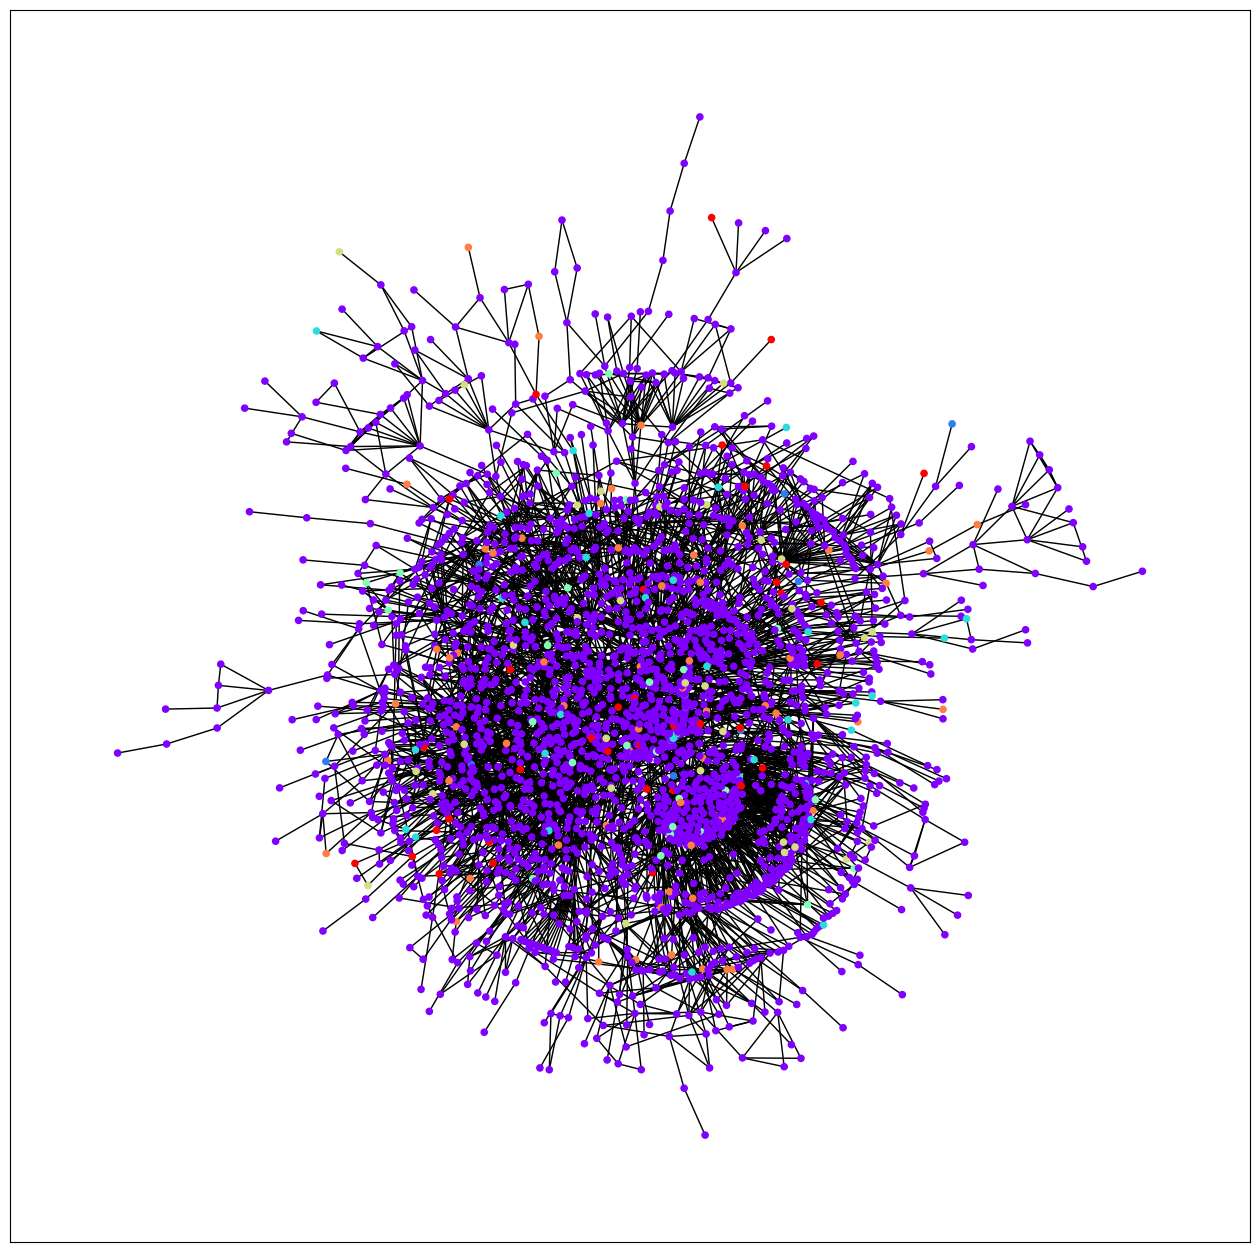

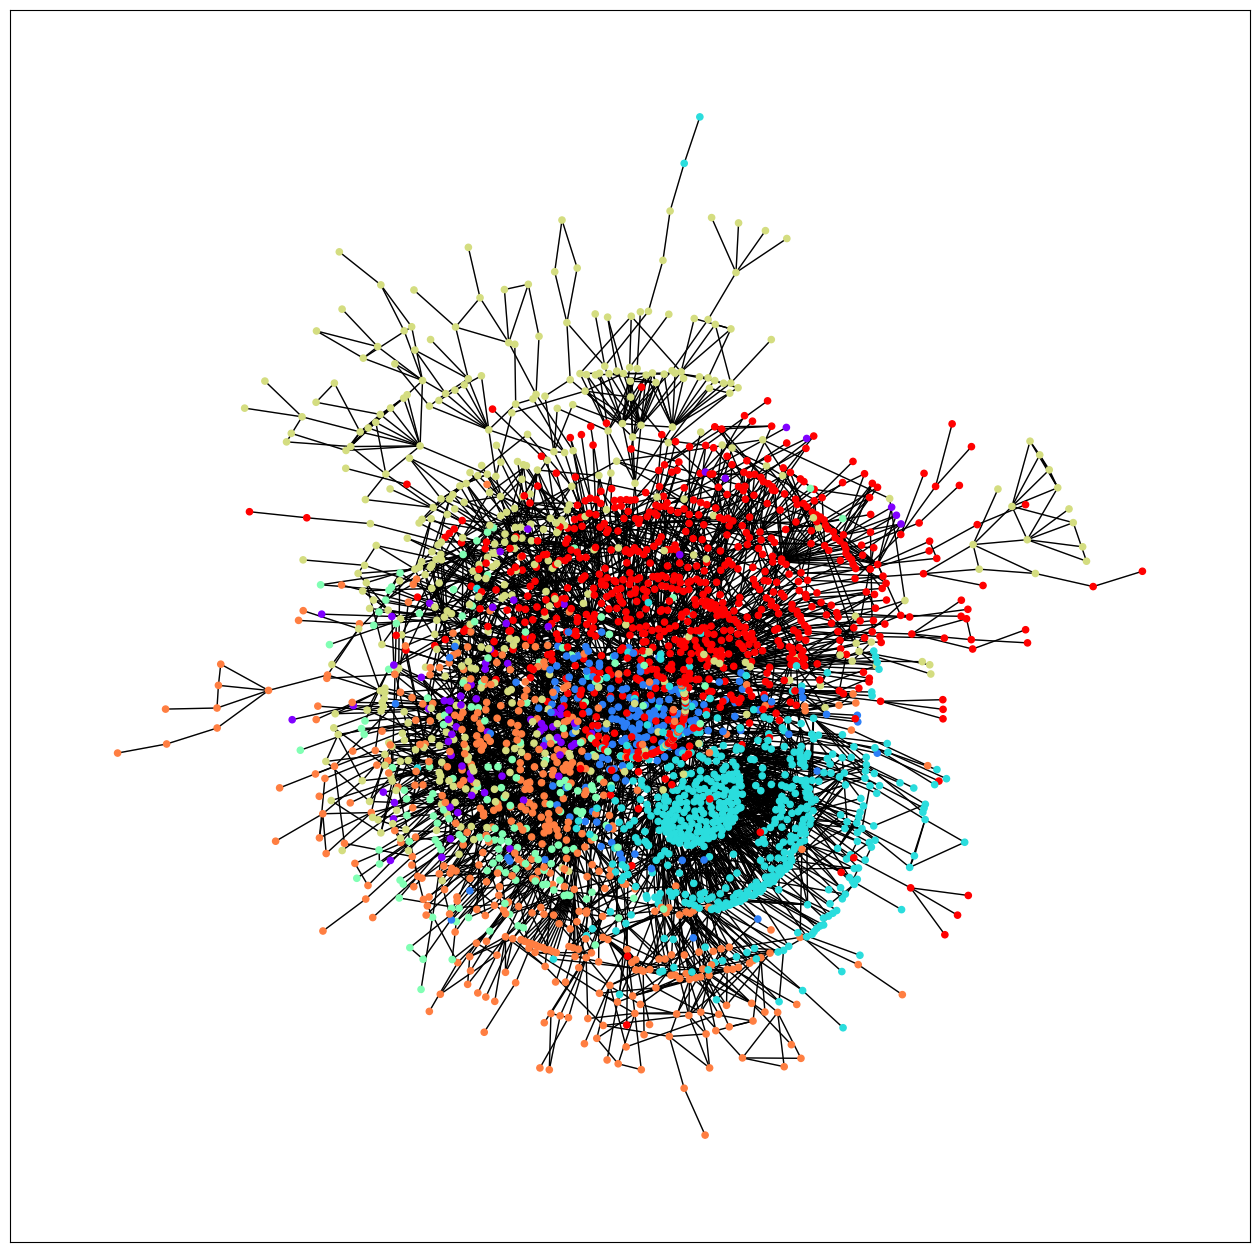

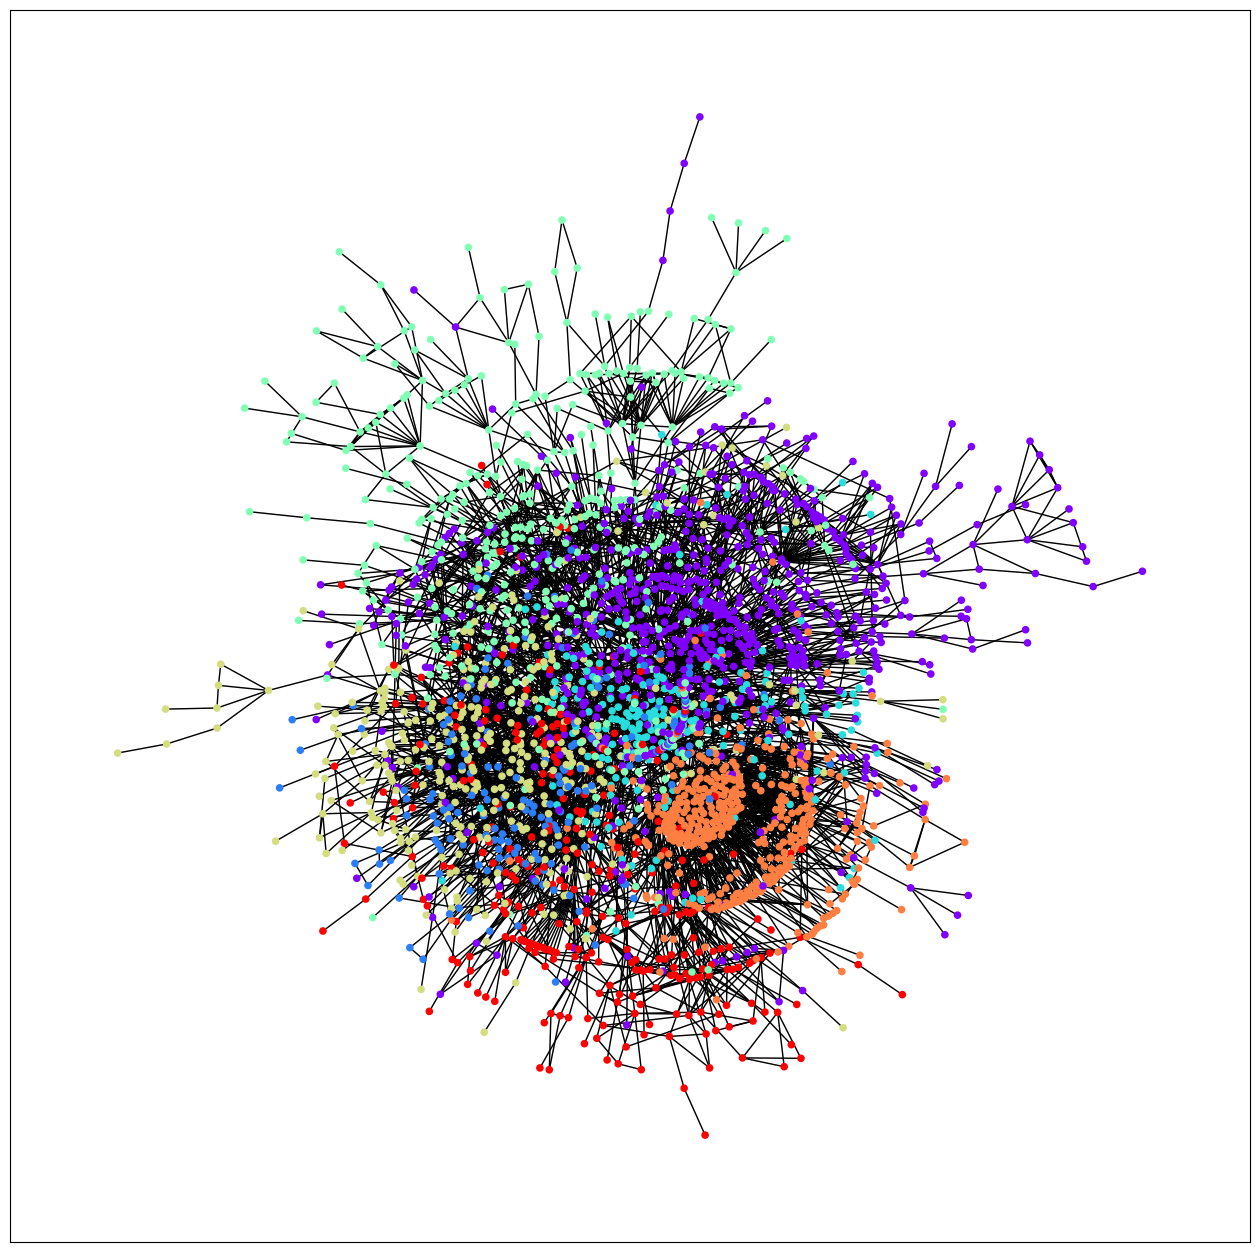

In [72]:
# Visualize the community structure

def visualize_community(edges_path, memberships_list):
    G = nx.Graph()
    edges = np.loadtxt(edges_path, dtype=int)
    G.add_edges_from(edges)
    pos = nx.kamada_kawai_layout(G)
    
    for memberships in memberships_list:
        # Create a consistent label-to-color mapping 
        unique_labels = sorted(np.unique(memberships))  # Get unique labels
        cmap = plt.cm.rainbow  # Choose a colormap
        label_to_color = {label: cmap(i / (len(unique_labels) - 1)) for i, label in enumerate(unique_labels)}
        colors = [label_to_color[memberships[node]] for node in G.nodes]

        plt.figure(figsize=(16, 16))
        nx.draw_networkx_edges(G, pos, alpha=0.1)
        nx.draw_networkx(G, pos, node_color=colors, with_labels=False, node_size=20)
        plt.show()

edges_path = 'dataset/cora/edges.txt'
memberships_list = [y_pred_spectral, y_pred_CDNMF, y_true]
visualize_community(edges_path, memberships_list)